# TMS Data Preprocessing for Accident Prediction

This notebook focuses on loading, cleaning, and preparing data for our accident prediction model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import json

# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

## 1. Load Data

We'll load data from CSV files exported from our database.

In [3]:
# Load data from CSV files
trips_df = pd.read_csv('csv_datasets/trips.csv')
vehicles_df = pd.read_csv('csv_datasets/vehicles.csv')
drivers_df = pd.read_csv('csv_datasets/drivers.csv')
routes_df = pd.read_csv('csv_datasets/routes.csv')

# Display basic info
print(f"Trips data shape: {trips_df.shape}")
print(f"Vehicles data shape: {vehicles_df.shape}")
print(f"Drivers data shape: {drivers_df.shape}")
print(f"Routes data shape: {routes_df.shape}")

Trips data shape: (100, 25)
Vehicles data shape: (5000, 23)
Drivers data shape: (1500, 20)
Routes data shape: (500, 16)


## 2. Data Exploration

In [4]:
# Check for missing values
print("\nMissing values in trips data:")
print(trips_df.isnull().sum())

print("\nMissing values in vehicles data:")
print(vehicles_df.isnull().sum())

print("\nMissing values in drivers data:")
print(drivers_df.isnull().sum())

print("\nMissing values in routes data:")
print(routes_df.isnull().sum())


Missing values in trips data:
vehicle_id                      0
driver_id                       0
route_id                        0
start_time                      0
end_time                       24
actual_duration                24
expected_duration               0
start_fuel_level                0
end_fuel_level                 24
fuel_consumed                  24
actual_distance                24
planned_distance                0
average_speed                  24
max_speed                      24
idle_time                      24
weather_conditions              0
traffic_conditions              0
on_time_status                  0
delay_reason                   78
cargo_weight                    0
cargo_type                      0
maintenance_issues_reported    94
incidents_reported             96
driver_fatigue_score            0
id                              0
dtype: int64

Missing values in vehicles data:
license_plate                   0
model                           0
capa

In [5]:
# Basic statistics for trips data
trips_df.describe()

,vehicle_id,driver_id,route_id,actual_duration,expected_duration,start_fuel_level,end_fuel_level,fuel_consumed,actual_distance,planned_distance,average_speed,max_speed,idle_time,cargo_weight,driver_fatigue_score,id
count,100.000000,100.000000,100.000000,76.000000,100.000000,100.000000,76.000000,76.000000,76.000000,100.000000,76.000000,76.000000,76.000000,100.000000,100.000000,100.000000
mean,992.830000,793.810000,253.860000,130.753310,128.964162,74.181419,49.660634,25.246807,103.597323,100.963694,48.932574,63.001968,16.215220,3895.415383,0.421952,50.500000
std,489.239423,425.692845,148.248292,60.236788,57.241759,14.785292,18.046583,8.600834,45.265988,43.964843,8.856985,12.497824,9.837392,2092.862117,0.154666,29.011492
min,12.000000,20.000000,13.000000,27.369424,27.478389,50.422007,11.663009,10.817573,23.600062,21.557157,30.794026,34.204795,1.834982,532.902078,0.105090,1.000000
25%,552.250000,434.500000,130.000000,90.185874,89.610279,63.216175,35.098560,18.851986,71.137198,72.371683,42.364061,55.015028,8.216546,2141.294921,0.307387,25.750000
50%,1135.500000,771.000000,246.000000,131.003713,123.342208,74.832108,51.285992,25.619564,97.929017,99.619094,48.872720,60.946909,13.710329,3933.686046,0.432745,50.500000
75%,1382.250000,1194.000000,381.000000,164.495400,166.153532,83.937825,64.171045,31.674456,132.398743,129.664671,54.733663,70.583545,22.965923,5539.040220,0.540213,75.250000
max,1753.000000,1407.000000,493.000000,305.353167,273.809405,99.660551,83.800703,39.744330,210.545957,195.907390,68.500595,94.139299,44.435669,7896.419469,0.691037,100.000000


In [6]:
# Check for incidents reported in trips
# We'll use this as our target variable for accident prediction
incidents_reported = trips_df['incidents_reported'].value_counts()
print("Incidents reported distribution:")
print(incidents_reported)

# Create a binary target variable for accident prediction
# 1 if there was an incident, 0 if not
trips_df['had_incident'] = trips_df['incidents_reported'].apply(lambda x: 0 if pd.isna(x) or x == '' else 1)
print("\nHad incident distribution:")
print(trips_df['had_incident'].value_counts())

Incidents reported distribution:
incidents_reported
Minor collision       2
Mechanical failure    2
Name: count, dtype: int64

Had incident distribution:
had_incident
0    96
1     4
Name: count, dtype: int64


## 3. Data Merging

Let's merge all the data to create a comprehensive dataset for our model.

In [7]:
# Merge trips with vehicles
merged_df = pd.merge(trips_df, vehicles_df, left_on='vehicle_id', right_on='id', how='left', suffixes=('', '_vehicle'))

# Merge with drivers
merged_df = pd.merge(merged_df, drivers_df, left_on='driver_id', right_on='id', how='left', suffixes=('', '_driver'))

# Merge with routes
merged_df = pd.merge(merged_df, routes_df, left_on='route_id', right_on='id', how='left', suffixes=('', '_route'))

# Check the shape of the merged dataframe
print(f"Merged data shape: {merged_df.shape}")
merged_df.head()

Merged data shape: (100, 85)


,vehicle_id,driver_id,route_id,start_time,end_time,actual_duration,expected_duration,start_fuel_level,end_fuel_level,fuel_consumed,actual_distance,planned_distance,average_speed,max_speed,idle_time,weather_conditions,traffic_conditions,on_time_status,delay_reason,cargo_weight,cargo_type,maintenance_issues_reported,incidents_reported,driver_fatigue_score,id,had_incident,license_plate,model,capacity,category,status,total_trips,total_distance_travelled,manufacture_year,fuel_efficiency,maintenance_score,last_maintenance_date,maintenance_frequency,engine_hours,idle_time_percentage,avg_speed,emissions_data,tire_wear_rate,breakdown_frequency,sensor_data_json,operational_cost_per_mile,driver_id_vehicle,route_id_vehicle,id_vehicle,name,email,license_number,total_trips_driver,total_earnings,safety_score,on_time_delivery_rate,experience_years,rest_compliance_rate,avg_speed_profile,harsh_braking_events,harsh_acceleration_events,fuel_efficiency_score,route_adherence,customer_satisfaction,training_level,certifications,preferred_routes,fatigue_score,id_driver,route_code,cost,start_location,end_location,estimated_travel_time,distance,avg_traffic_density,avg_fuel_consumption,historical_delays,weather_risk_factor,time_of_day_efficiency,day_of_week_efficiency,seasonal_factors,complexity_score,historical_incidents,id_route
0,364,1160,32,2024-05-24T00:18:47.559512,2024-05-24T02:35:00.300704,136.212353,161.613608,55.989692,43.579845,12.409847,108.963933,112.918522,47.997379,70.478672,26.110325,Clear,Heavy,True,NaN,4878.589032,Perishable,NaN,NaN,0.261006,1,0,VEH0364,Toyota Hilux,34,Coaster,inactive,256,96010.814405,2023,11.398683,0.761296,2025-02-16,40,12665.091408,0.212959,49.257524,"{""co2"": 116.52022007476408, ""nox"": 44.64334560...",0.001625,0.032580,"{""engine_temp"": 193.783576979761, ""oil_pressur...",1.010276,1160.0,202.0,364,Nyiraneza Pierre,nyiraneza.pierre758@gov.rw,DL01160,172,22899.16,0.506215,0.725264,1.539643,0.916913,"{""highway"": 67.2677351400046, ""city"": 17.24205...",36,27,0.899839,0.834821,4.484788,2,"[""Basic""]","[""R440"", ""R196"", ""R422""]",0.121099,1160,R032,95.947706,Rusizi (Cyangugu),Kigali,2.693560,112.918522,0.800000,18.941057,14.062464,0.340802,"{""0"": 0.9166085576070506, ""1"": 0.9718283365208...","{""0"": 0.9596028912793126, ""1"": 0.9990329362043...","{""winter"": 0.733885170613516, ""spring"": 0.8439...",3.391734,6,32
1,921,622,19,2024-10-13T04:38:39.559512,2024-10-13T06:27:44.521299,109.082696,92.709755,67.509705,47.802018,19.707687,95.512498,89.763671,52.535829,66.186559,13.455473,Rain,Heavy,False,Traffic congestion,5693.327659,General,NaN,NaN,0.451859,2,0,VEH0921,Higer KLQ6112,51,Coach,active,242,7613.060204,2013,9.644527,0.863439,2024-12-21,146,9821.223768,0.244428,51.594237,"{""co2"": 161.08268277306271, ""nox"": 23.75661458...",0.003102,0.045010,"{""engine_temp"": 181.36181407723276, ""oil_press...",0.794221,622.0,NaN,921,Nsengimana Jeanne,nsengimana.jeanne435@gmail.com,DL00622,26,14150.55,0.630837,0.733868,8.630609,0.708598,"{""highway"": 57.33137101685699, ""city"": 21.0422...",19,33,0.778614,0.775720,4.854644,4,"[""Basic"", ""Advanced""]","[""R412"", ""R345"", ""R449""]",0.450980,622,R019,101.115285,Ngoma,Kigali,1.545163,89.763671,0.800000,22.473872,18.364364,0.764827,"{""0"": 0.7665626533061858, ""1"": 0.9966596596199...","{""0"": 0.8417143671579296, ""1"": 0.9698986363155...","{""winter"": 0.620064424707388, ""spring"": 0.7742...",6.310328,7,19
2,1278,581,462,2025-04-04T09:53:27.559512,2025-04-04T13:37:02.550819,223.583188,203.847914,73.810596,43.360136,30.450460,150.742884,141.607867,40.452831,46.691878,22.750123,Clear,Light,True,NaN,3925.824121,General,NaN,NaN,0.185602,3,0,VEH1278,Mitsubishi Fuso,76,Cab,inactive,184,83244.050027,2018,9.891823,0.545133,2024-12-15,63,13991.886243,0.244477,41.859261,"{""co2"": 117.16434357506475, ""nox"": 14.69562524...",0.005120,0.008860,"{""engine_temp"": 208.29819326988715, ""oil_press...",1.530752,581.0,NaN,1278,Munyemana Francoise,munyemana.francoise678@outlook

## 4. Feature Engineering

Let's create some features that might be useful for accident prediction.

In [8]:
# Parse JSON fields
def parse_json_field(df, column):
    """Parse JSON string fields into dictionaries"""
    try:
        df[column + '_parsed'] = df[column].apply(lambda x: {} if pd.isna(x) else json.loads(x))
        return True
    except:
        print(f"Could not parse {column} as JSON")
        return False

# Parse JSON fields
json_fields = [
    'sensor_data_json', 'avg_speed_profile', 'certifications',
    'time_of_day_efficiency', 'day_of_week_efficiency', 'seasonal_factors'
]

for field in json_fields:
    if field in merged_df.columns:
        parse_json_field(merged_df, field)

In [9]:
# Create new features

# Calculate speed variance (difference between max and average speed)
merged_df['speed_variance'] = merged_df['max_speed'] - merged_df['average_speed']

# Calculate fuel efficiency during trip
merged_df['trip_fuel_efficiency'] = merged_df['actual_distance'] / merged_df['fuel_consumed'].replace(0, np.nan)

# Calculate deviation from planned route
merged_df['route_deviation'] = (merged_df['actual_distance'] - merged_df['planned_distance']) / merged_df['planned_distance']

# Calculate time deviation
merged_df['time_deviation'] = (merged_df['actual_duration'] - merged_df['expected_duration']) / merged_df['expected_duration']

# Calculate vehicle age
current_year = 2025  # Update this to the current year
merged_df['vehicle_age'] = current_year - merged_df['manufacture_year']

# Calculate idle time percentage for the trip
merged_df['trip_idle_percentage'] = merged_df['idle_time'] / merged_df['actual_duration'] * 100

# Weather risk indicator (binary for now, can be improved)
merged_df['bad_weather'] = merged_df['weather_conditions'].apply(
    lambda x: 1 if pd.notna(x) and any(w in str(x).lower() for w in ['rain', 'snow', 'storm', 'fog', 'ice']) else 0
)

# Traffic risk indicator
merged_df['heavy_traffic'] = merged_df['traffic_conditions'].apply(
    lambda x: 1 if pd.notna(x) and any(t in str(x).lower() for t in ['heavy', 'congested', 'jam']) else 0
)

## 5. Data Cleaning and Preparation

In [10]:
# Handle missing values
# For numerical columns, fill with median
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# For categorical columns, fill with 'Unknown'
categorical_cols = merged_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    merged_df[col] = merged_df[col].fillna('Unknown')

# Check if we still have missing values
print("Missing values after cleaning:")
print(merged_df.isnull().sum().sum())

Missing values after cleaning:
0


In [11]:
# Select features for our model
features = [
    # Trip features
    'actual_duration', 'expected_duration', 'fuel_consumed', 'actual_distance',
    'average_speed', 'max_speed', 'idle_time', 'driver_fatigue_score',
    'speed_variance', 'trip_fuel_efficiency', 'route_deviation', 'time_deviation',
    'trip_idle_percentage', 'bad_weather', 'heavy_traffic',
    
    # Vehicle features
    'vehicle_age', 'maintenance_score', 'maintenance_frequency', 'engine_hours',
    'idle_time_percentage', 'breakdown_frequency',
    
    # Driver features
    'safety_score', 'experience_years', 'rest_compliance_rate',
    'harsh_braking_events', 'harsh_acceleration_events',
    
    # Route features
    'distance', 'avg_traffic_density', 'weather_risk_factor', 'complexity_score',
    'historical_incidents'
]

# Select only the columns that exist in our dataframe
features = [f for f in features if f in merged_df.columns]

# Create X (features) and y (target)
X = merged_df[features]
y = merged_df['had_incident']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (100, 31)
Target shape: (100,)


In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (80, 31)
Testing set shape: (20, 31)


In [13]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrame to keep column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled_df.head()

,actual_duration,expected_duration,fuel_consumed,actual_distance,average_speed,max_speed,idle_time,driver_fatigue_score,speed_variance,trip_fuel_efficiency,route_deviation,time_deviation,trip_idle_percentage,bad_weather,heavy_traffic,vehicle_age,maintenance_score,maintenance_frequency,engine_hours,idle_time_percentage,breakdown_frequency,safety_score,experience_years,rest_compliance_rate,harsh_braking_events,harsh_acceleration_events,distance,avg_traffic_density,weather_risk_factor,complexity_score,historical_incidents
0,-0.908310,-1.015900,-1.457601,-1.227405,-1.343147,-0.817901,-0.132955,0.928999,0.318457,-0.307378,1.590014,1.815468,1.054152,0.795395,-0.733799,-0.298431,0.104807,1.308143,-1.772517,0.633122,0.854531,1.297373,-0.491647,1.429993,0.625635,0.394498,-1.163654,0.922415,-1.135613,-0.538042,-0.783055
1,-1.253586,-0.821809,-1.900954,-0.639130,2.390038,2.967985,-0.256196,-1.612727,2.506317,0.915013,0.100200,-1.796849,1.737504,0.795395,-0.733799,1.406890,0.602280,-0.742953,-1.023999,0.555513,1.579895,0.763656,1.583122,-1.676982,1.824456,-1.320709,-0.581369,0.922415,-0.060126,-0.025554,-0.783055
2,0.008355,-0.107296,0.061707,-0.100960,0.015230,-0.111059,-0.245435,-0.086714,-0.135129,-0.255097,0.098694,0.019410,-0.054981,0.795395,-0.733799,-0.298431,0.300403,0.738395,-1.111068,-1.731976,0.806281,0.051966,-1.586179,-1.565319,-1.022745,-0.977668,0.197074,0.922415,-1.591804,-0.294825,-0.545766
3,2.330703,1.930089,-1.436431,1.939126,-0.710865,-0.805657,2.533857,0.523324,-0.639456,2.869458,0.385522,0.416852,0.536863,-1.257237,1.362770,-1.272900,-1.022040,0.670025,0.371118,-0.925632,-1.248486,1.211841,1.623072,1.419926,-0.348407,-0.891907,1.660132,0.922415,1.630604,1.600957,-0.308476
4,0.790291,0.349983,1.282237,0.431851,-0.864366,0.031606,1.884627,0.732766,1.367804,-0.461920,0.959283,1.443145,1.408388,-1.257237,1.362770,0.432421,0.843393,0.442125,-1.077635,-1.147981,0.195464,-0.686068,0.281525,-1.333038,0.700561,-1.063428,0.286957,-0.930744,-1.068526,-0.949956,0.877971


## 6. Feature Importance Analysis

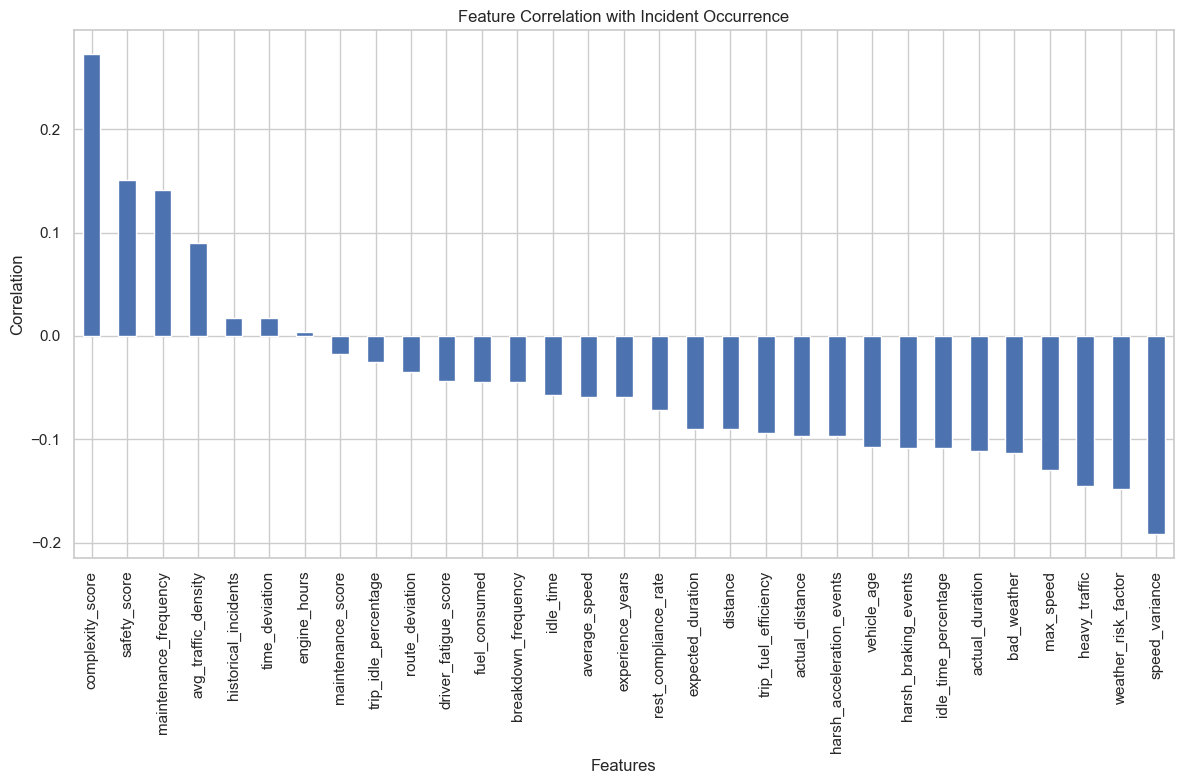

In [14]:
# Calculate correlation with target
correlation = X_train.corrwith(y_train).sort_values(ascending=False)

# Plot correlation
plt.figure(figsize=(12, 8))
correlation.plot(kind='bar')
plt.title('Feature Correlation with Incident Occurrence')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Save the processed data for modeling
X_train_scaled_df.to_csv('csv_datasets/X_train_scaled.csv', index=False)
X_test_scaled_df.to_csv('csv_datasets/X_test_scaled.csv', index=False)
y_train.to_csv('csv_datasets/y_train.csv', index=False)
y_test.to_csv('csv_datasets/y_test.csv', index=False)

# Save the scaler for later use
import joblib
joblib.dump(scaler, 'models/scaler.pkl')

print("Data preprocessing complete. Files saved for modeling.")

Data preprocessing complete. Files saved for modeling.
